In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
#allows to print the dataframe nicely
from IPython.core import display as ICD
# !pip install plotly
# import plotly.plotly as py
# from plotly.graph_objs import *
# import plotly.tools as tls
from scipy import stats

In [2]:
# import additional packages to insepct data and clean them
import pandas as pd
import os 
import random 
from zipfile import ZipFile
import datetime

In [3]:
# import helping functions from the implementation file
#from proj1_helpers import load_csv_data
from proj1_helpers import *
import implementations
from additional_implementations import *
import seaborn as sns
import physics as phy
import PCA as pca


### Loading relevant files

In [4]:
# import zipped files from the github repository
data_folder='./data/'
zip_file = ZipFile(data_folder+'all.zip')
# zip file creates a list of files with certain properties
zip_file.infolist()

[<ZipInfo filename='train.csv' compress_type=deflate file_size=48103379 compress_size=17670847>,
 <ZipInfo filename='test.csv' compress_type=deflate file_size=109335584 compress_size=40089137>,
 <ZipInfo filename='sample-submission.csv' compress_type=deflate file_size=5682394 compress_size=1263762>]

In [5]:
# now we want to access the 'filename' property in the zipfile variable
# and we create a dictionary of dataframe
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}
df_train=dfs['train.csv']
df_test=dfs['test.csv']

# Code Outline

### Data Inspection and preparation 
In the first section the attributes provided were cleaned and studied. 

### Feature Generation
On the one hand on the base of the scientific knowledge behind the Boson data and on the base of the features data, a method to select features was prepared. On the other a Pricipal Component Analysis was also carried out to perform a feature selection. Hence, before applying regression algorithms, different feature spaces were generated; in this manner the performance results obtained with the different features could be compared in the testing phase and an evaluation of the most important features could be done.

### Feature Augmentation
The feature spaces were augmented by carrying out a polynomial expansion

### Testing
Hence the performance of a selection of regression models was compared with different features in order to obtain the best combination according to the prediction results obtained in the Kaggle competition.

## Data Inspection and preparation

The first step was understanding the data structure and learning about the features we have been provided with. By studying the scientific backgroun about the experiment in the [competition description](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), the relationship between the features was understood. 

In [6]:
df_train.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


It was soon discovered that almost half of the datapoints were getting values not in the range of normal values for each features. Discarting all these data was not an option hence an alternative solution was proposed.

In [7]:
# example of the part of the dataset where a column would get a value not in the normal range of values
df_train[df_train['DER_lep_eta_centrality']==-999.0].head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
1,100001,b,160.937,68.768,103.235,48.146,-999.0,-999.0,-999.0,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.0,-999.0,-999.0,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.0,-999.0,-999.0,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.0,-999.0,-999.0,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.0,-999.0,-999.0,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.0,-999.0,-999.0,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.0,-999.0,-999.0,0.000
7,100007,s,154.916,10.418,94.714,29.169,-999.0,-999.0,-999.0,2.897,...,-1.761,187.299,1,30.638,-0.715,-1.724,-999.0,-999.0,-999.0,30.638


In [8]:
# example of number of data points to be deleted considering the feature 'DER_lep_eta_centrality' only
df_train[df_train['DER_lep_eta_centrality']==-999.0].shape[0]

177457

A relationship between the values attained by each feature was present: in fact it was found that the value obtained by 'PRI_jet_num', the number of jets during the collision, was directly influencing the values of a big group of other features. In particular any time its value would be smaller or equal to one, a group of features would automatically get values out of the normal range. 

In [9]:
# example of relationship between 'PRI_jet_num' and 'DER_lep_eta_centrality'
df_train.index[df_train['DER_lep_eta_centrality']==-999.0]
df_train.index[df_train['PRI_jet_num']<=1]

# checking that the indices at which -999.0 values were obtained were also the same in which 'PRI_jet_num' was less\
# or equal to 1
if df_train.index[df_train['PRI_jet_num']<=1].all()==df_train.index[df_train['DER_lep_eta_centrality']==-999.0].all():
    print ('When PRI_jet_num is less or equal to 1, DER_lep_eta_centrality gets values out of range')

When PRI_jet_num is less or equal to 1, DER_lep_eta_centrality gets values out of range


It was then found that the value of 'PRI_jet_num' would automatically influenc the values of the following features: 'DER_deltaeta_jet_jet','DER_mass_jet_jet', 'DER_prodeta_jet_jet','DER_lep_eta_centrality', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta','PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi'. Hence the dataset was divided in two smaller dataset. One containing the features depending directly on 'PRI_jet_num' (df_train_dependent_features) and another with those not directly dependent on 'PRI_jet_num' (df_train_independent_features).

#### Baseline Test

The baseline dataset was produced after the above analysis was done

In [10]:
df_train_baseline=clean_pred_Id(df_train)

The values of 'b' and 's' which were indicating the presence of a boson or not are substituted with -1 and 1.

In [11]:
y_baseline=assign_y_values(df_train)

#### Feature Space 1: Selection based on physics knowledge and correlation coefficients

The feature space was further reduced by looking at the correlation coefficients

In [12]:
df_train_FS1=clean_pred_Id(df_train)

The values of 'b' and 's' which were indicating the presence of a boson or not are substituted with -1 and 1.

In [13]:
y_FS1=assign_y_values(df_train)

In [14]:
counts={}
for column_name in df_train_FS1.columns.values:
    
    check=df_train_FS1[column_name]==-999.0
    counts[column_name]=np.sum(check.astype('int'))
counts

{'DER_mass_MMC': 38114,
 'DER_mass_transverse_met_lep': 0,
 'DER_mass_vis': 0,
 'DER_pt_h': 0,
 'DER_deltaeta_jet_jet': 177457,
 'DER_mass_jet_jet': 177457,
 'DER_prodeta_jet_jet': 177457,
 'DER_deltar_tau_lep': 0,
 'DER_pt_tot': 0,
 'DER_sum_pt': 0,
 'DER_pt_ratio_lep_tau': 0,
 'DER_met_phi_centrality': 0,
 'DER_lep_eta_centrality': 177457,
 'PRI_tau_pt': 0,
 'PRI_tau_eta': 0,
 'PRI_tau_phi': 0,
 'PRI_lep_pt': 0,
 'PRI_lep_eta': 0,
 'PRI_lep_phi': 0,
 'PRI_met': 0,
 'PRI_met_phi': 0,
 'PRI_met_sumet': 0,
 'PRI_jet_num': 0,
 'PRI_jet_leading_pt': 99913,
 'PRI_jet_leading_eta': 99913,
 'PRI_jet_leading_phi': 99913,
 'PRI_jet_subleading_pt': 177457,
 'PRI_jet_subleading_eta': 177457,
 'PRI_jet_subleading_phi': 177457,
 'PRI_jet_all_pt': 0}

In [15]:
df_train_FS1, median = phy.physics_train(df_train_FS1, full_cleaning=False)

In [16]:
corr_FS1=df_train_FS1.corr()
corr_FS1.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt
DER_mass_MMC,1.000000,0.121331,0.804807,0.044962,0.464608,0.017307,0.138637,0.062635,0.059554,0.259609,0.002617,-0.003494,0.322839,0.004306,-0.002982,0.062620,0.000779,0.106596,0.039144,0.031621
DER_mass_transverse_met_lep,0.121331,1.000000,0.190109,-0.249116,0.043251,0.017758,-0.146837,0.349504,-0.419757,-0.145464,-0.002109,0.001132,0.310648,-0.006777,0.000340,0.183716,-0.015925,-0.167811,-0.210537,-0.210009
DER_mass_vis,0.804807,0.190109,1.000000,-0.062562,0.579712,-0.000702,0.088685,0.097490,-0.090846,0.290011,0.002127,-0.003624,0.405482,0.002196,-0.002018,-0.087330,-0.001467,0.053300,-0.026860,-0.052902
DER_pt_h,0.044962,-0.249116,-0.062562,1.000000,-0.539379,0.310501,0.832733,0.089187,0.539356,0.407421,0.001665,0.005248,0.360939,0.008354,-0.002923,0.679585,0.008585,0.782547,0.623401,0.808616
DER_deltar_tau_lep,0.464608,0.043251,0.579712,-0.539379,1.000000,-0.148081,-0.432603,0.047046,-0.205441,-0.202035,0.003632,-0.011229,-0.069957,0.000699,-0.000776,-0.402345,-0.001570,-0.407002,-0.347904,-0.448737


In [17]:
spears=pd.DataFrame(stats.spearmanr(df_train_FS1)[0])
spears.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.035924,0.752812,0.054944,0.427170,-0.020733,0.214596,-0.057620,0.078170,0.351865,0.002296,-0.003353,0.307801,0.001682,-0.002275,0.061575,0.001586,0.122314,0.034086,0.041573
1,0.035924,1.000000,0.106169,-0.312263,0.039784,-0.033817,-0.230117,0.370798,-0.367944,-0.240391,-0.002622,0.001615,0.282696,-0.009097,-0.000387,0.276755,-0.017198,-0.237319,-0.267018,-0.299374
2,0.752812,0.106169,1.000000,-0.086651,0.592098,-0.023775,0.136481,-0.003055,-0.096586,0.375304,0.002778,-0.006287,0.421104,0.000694,-0.000233,-0.187260,-0.001623,0.040188,-0.068506,-0.087177
3,0.054944,-0.312263,-0.086651,1.000000,-0.488339,0.375494,0.805124,-0.044072,0.614896,0.232492,0.005899,0.004947,0.191882,0.016317,-0.002427,0.422934,0.009492,0.771787,0.769568,0.849246
4,0.427170,0.039784,0.592098,-0.488339,1.000000,-0.122927,-0.371489,0.084804,-0.200441,-0.117411,0.003147,-0.011490,-0.013426,-0.001050,-0.000133,-0.405530,-0.002033,-0.365896,-0.367983,-0.444967


The following correlation can be considered meaningful with a limit of 0.7:

-  DER_sum_pt 0.85 with PRI_jet_num, 
-  PRI_met_sumet 0.79 with DER_sum_pt, 
-  PRI_jet_all_pt 0.95 with DER_sum_pt, 
-  PRI_jet_all_pt 0.90 with PRI_jet_num, 
-  PRI_jet_all_pt 0.77 with PRI_met_sumet, 
-  DER_mass_MMC 0.67 with DER_mass_vis, 
-  DER_pt_h 0.7 with PRI_met_sumet, 
-  DER_pt_h 0.79 with PRI_jet_all_pt
-  PRI_jet_all_pt 0.79 with DER_pt_h, 
-  DER_pt_h 0.79 with DER_sum_pt

As it can be seen there is a strong correlation between the above features which they can all be reconduced to the presence of PRI_jet_num. As a matter of fact there is a clear dominant linear relationship between most of the features outlined above; in other words PRI_jet_num retains most of the information of the other features which depend on it. For these reasons the dependent features will be discarded for the analysis.

From the analysis above, it has been decided that the features which are going to be used for the regression are the independent ones from which PRI_jet_num, DER_sum_pt, PRI_met_sumet and DER_pt_h have been considered redundant since they depend on PRI_jet_all_pt.

In [18]:
df_train_FS1=clean_pred_Id(df_train)

In [19]:
df_train_FS1, median = phy.physics_train(df_train_FS1)

#### Feature Space 2: Pricipal Components Analysis feature selection

In [20]:
df_train_FS2=df_train

In [21]:
df_train_FS2=clean_pred_Id(df_train)

The values of 'b' and 's' which were indicating the presence of a boson or not are substituted with -1 and 1.

In [22]:
y_FS2=assign_y_values(df_train)

In [23]:
df_train_FS2[df_train_FS2==-999.0]=0

In order to have an idea of the distribution of each feature when the boson was assigned a density plot of the standardized feature was made. The distribution of each feature could then be highlighted individually.

Text(0,0.5,'Density')

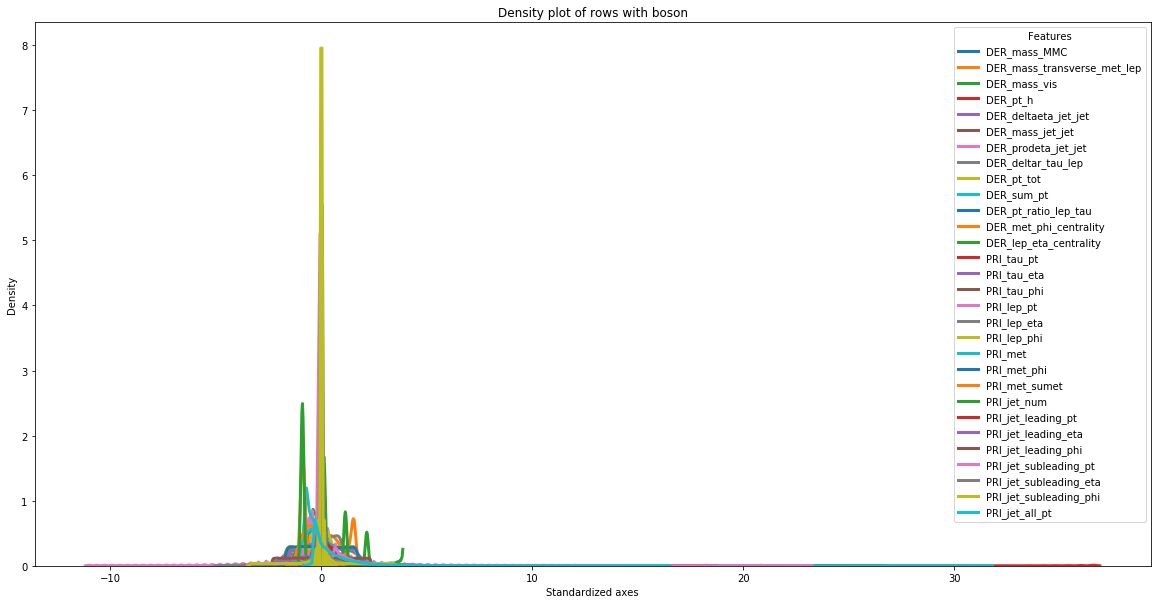

In [24]:
features = df_train_FS2.columns.values

fig=plt.figure(figsize=(20,10))
for feature in features:
    
    # Subset for boson and not boson
    subset_boson = df_train_FS2[df_train['Prediction'] == 'b']
    
    standard,_,_=standardize_personal(subset_boson[feature])
    # Draw the density plot
    sns.distplot(standard, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = feature)
    
# Plot formatting

plt.legend(prop={'size': 10}, title = 'Features')
plt.title('Density plot of rows with boson')
plt.xlabel('Standardized axes')
plt.ylabel('Density')

The number of principal components was determined visualizing the variance explained and ranking the eigenvector of the covariance matrix.

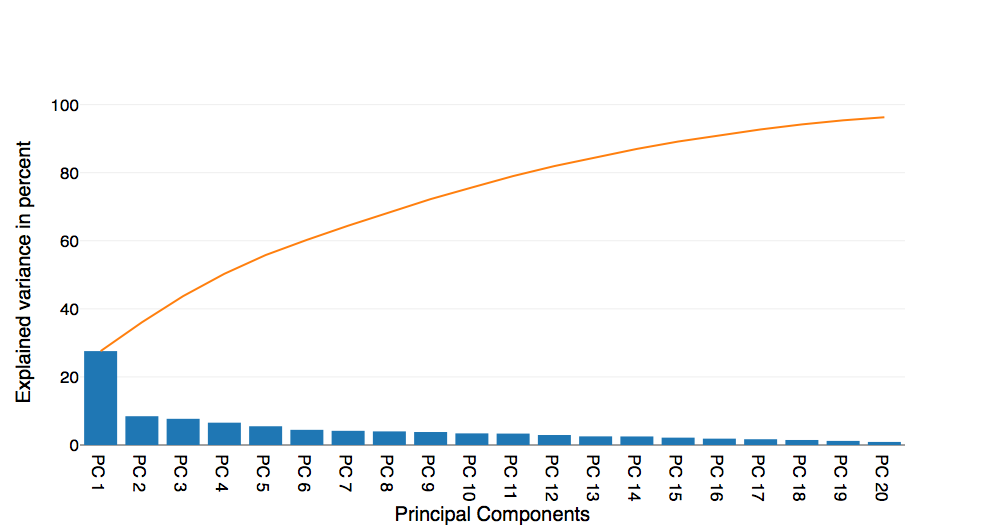

Hence the matrix was standardized and the principal components obtained. The mean and the standard deviation were also obtained in order to standardize the test data with the same parameters

In [25]:
number_pa=20
df_train_FS2_std_transf, matrix_w, mean_train, std_train=pca.perform_PCA(df_train_FS2,number_pa)

## Testing

Firstly the dataset and arrays were renamed in order to be able to select the desired version of the feature space

In [26]:
tx_train=df_train_FS1
y_train=y_FS1

#### Least Square

The baseline test is produced with least square and the baseline feature space

In [27]:
w,loss=implementations.least_squares(y_train,tx_train)

In [28]:
y_pred=predict_labels(w,tx_train)
print('')
print('Learning Performance: ',list(y_pred*y_train).count(1.)/len(tx_train))


Learning Performance:  0.722772


#### Ridge Regression

The following Ridge regression performs a cross validation and an optimization of the degree and the hyperparamter lambda.

In [29]:
#Run Optimization algorithm 
lambdas=np.logspace(-10,-1,2)
degrees=np.linspace(1,15,3).astype('int')
k_fold=4
mses= np.zeros((len(degrees), len(lambdas),2))
print('STARTING OPTIMIZATION')
for ind_degree,degree in enumerate(degrees):
    tx_train_selection_polynomial=polynomial_features_simple(tx_train, degree)
    print('Degree under optimization: ',degree)
    for ind_lambda,lambda_ in enumerate(lambdas):
        w, loss_tr, loss_te = cross_validation_ridge_loop(y_train, tx_train_selection_polynomial, lambda_, k_fold, seed=1)
        mses[ind_degree, ind_lambda][0]=loss_tr
        mses[ind_degree, ind_lambda][1]=loss_te
        
mse_tr_final, degree_final,lambda_final, min_row, min_col=get_best_parameters(degrees, lambdas, mses[:,:,0],return_idx=True)
mse_te_final=mses[min_row,min_col,1]
tx_train_selection_polynomial=polynomial_features_simple(tx_train, degree_final)
w_final,loss=implementations.ridge_regression(y_train,tx_train_selection_polynomial,lambda_final)
print('')
print('MSE train: ',mse_tr_final,'   MSE test: ',mse_te_final)
print('Degree:    ',degree_final,'   Lambda:   ',lambda_final)

y_pred=predict_labels(w_final,tx_train_selection_polynomial)
print('')
print('Learning Performance: ',list(y_pred*y_train).count(1.)/len(tx_train_selection_polynomial))



STARTING OPTIMIZATION
Degree under optimization:  1
Degree under optimization:  8


KeyboardInterrupt: 

#### Logistic Regression

Redefine y values according to the sigmoid function

In [30]:
y_logistic=assign_y_values(df_train, logistic=True)

The degree of the polynomial was not optimized due to computational inability of the regression to converge

In [31]:
tx_train_selection_polynomial=polynomial_features_simple(tx_train, 3)

In [32]:
gamma = 0.000001
lambda_ = 0.0001
points=7000
tx_train_selection_polynomial=tx_train_selection_polynomial[:points]
y_logistic=y_logistic[:points]

initial_w = np.zeros((tx_train_selection_polynomial.shape[1], 1))
# the maximum number of iteration was set to 10 but already after 2 iterations the loss was diverging
max_iters = 2
w,loss=implementations.reg_logistic_regression(y_logistic, tx_train_selection_polynomial, lambda_, initial_w, max_iters, gamma, keeptrack=False, log_info=True)

Current iteration=0, loss=33964211.8474406


KeyboardInterrupt: 

## Feature Spaces Test Examples

#### Baseline Feature Space Test

In [33]:
df_test_baseline=clean_pred_Id(df_test)

The values of 'b' and 's' which were indicating the presence of a boson or not are substituted with -1 and 1.

#### Feature Space 1 Test

Apply the same feature transformation of the training set

In [34]:
df_test_FS1=clean_pred_Id(df_test)
#Apply the required feature selection
df_test_FS1=phy.physics_test(df_test_FS1, median)
#Create the test matrix
tx_test_FS1_polynomial=polynomial_features_simple(df_test_FS1, degree_final)

NameError: name 'degree_final' is not defined

#### Feature Space 2 Test

Apply the same feature transformation of the training set

In [35]:
df_test_FS2=clean_pred_Id(df_test)
df_test_FS2_std_transf=pca.apply_PCA_to_test(df_test_FS2,matrix_w, mean_train, std_train)